# A Model Parameter Exercise<a name = 'top'></a>

A new respiratory virus has begun circulating in another country. So far, epidemiological investigations have yielded the data below. If a vaccine, with 80% effectiveness (at reducing susceptibility, no reduction in infectiousness), becomes available before this virus begins sustained transmission in your own country, what is the critical coverage required of this vaccine?
Assume that the source country and your own country are epidemiologically equivalent (i.e. that disease transmission follows the same parameters in both settings).

* All infected individuals go through an incubation period, which lasts on average for 4 days. During this time, individuals are not infectious, nor do they have any excess mortality risk.  

* All infected individuals eventually develop symptoms, and the mean duration of symptoms is 5 days.  

* Symptomatic individuals are infectious, as well as having a 3% case fatality rate. Those who survive the infection are thought to have full, long-term immunity.  

* In the source country, the peak prevalence (i.e. maximum number of symptomatic people during the epidemic) was 8% of the population.

[1. Model Diagram](#diagram)  
[2. Parameters you know or can calculate](#params)  
[3. Model equations and function](#equations)  
[4. Manual calibration](#mancal)  
. [4.1 Run and plot model](#model)  
. [4.2 Manually calibrate to estimate 𝛽](#manual)  
[5. Vaccine coverage](#vaccine)  
[6. Extra: Towards automated calibration](#auto)  
. [6.1 (extra) Automated calibration: distance function](#distfn)  
. [6.2 optim(): one-dimensional optimisation](#optim)


## 1. Model Diagram<a name='diagram'></a>

A good first thing to do is draw a model diagram. What do you know about the disease so far? Incorporating everything into a model, you should have an SLIR model structure like this:  
*(remember the difference between a latent phase and an asymptomatic phase)*

<img src="w7_nb5_diagram.png">


In [1]:
library(deSolve)
library(ggplot2)

## 2. Parameters you know or can calculate<a name = 'params'></a> ([return to top](#top))

In [2]:
### YOUR CODE HERE ###
## It's usually good to start off by writing what we know. 
## Might as well tell R these things:

# incubation period = 4 days
r     <- 1/4

# mean duration of symptoms = 5 days, therefore rate of recovery:
gamma <- 1/5

# and case fatality rate (cfr):
cfr   <- 3/100 # 3%

We don't know mu, the mortality rate. But we can calculate it using competing hazard theory:

In [19]:
[SF could do with more explanation here, in a comment at top or line by line comments]
# mu / (gamma+mu)  = cfr = 0.03   # competing hazards 
# mu = 0.03*(gamma)+0.03*(mu)
# 0.97*mu = 0.03*gamma = 0.03*1/5

mu <- 0.03*gamma/0.97

mu

[1] 0.006185567

So now we need to work towards working out the vaccine coverage needed.

If you can't remember (or derive them yourself each time!), the equation you need is derived from the equation for $R_{eff}$. In turn (see below), to use that equation, you need to know the value of beta.  

So you don't yet have a value for $\beta$, and this time, you also don't have the series of data that you have had in previous etivities on calibration, to find $\beta$. But there's one remaining piece of data: the peak prevalence is 8%. At this stage you can use the parameters you have already found, along with the model diagram, to code this model in R. You can then determine what value of beta gives you this required peak prevalence.

## 3. Model equations and function<a name = 'equations'></a>  ([return to top](#top))

The equations which go with your model above are:

$\frac{dS}{dt} = -\lambda S   \qquad \quad   = -\beta \frac{I}{N} S $
  
$\frac{dL}{dt} =  \ \lambda S - rL \ \quad = \; \beta \frac{I}{N} S  - rL $
  
$\frac{dI}{dt} =  \ rL - \mu I - \gamma I $
  
$\frac{dR}{dt} =  \ \gamma I $

In [1]:
# RUN THIS CELL to
# define the disease model function [SF 'define a function for this disease model']

[SF more descriptive function name, as before. eg SLIR_model. Though might be more confusing if these are sometimes denoted by _fn and  sometimes _model?]
    
SLIR_fn <- function(time, state, parameters) { 

    with(as.list(c(state, parameters)), {
        
        N  <- S + L + I + R
        
        ## model equations
        dS <- -beta * I/N * S
        dL <-  beta * I/N * S - r * L
        dI <-  r * L - mu * I - gamma * I
        dR <-  gamma * I
    
    return(list(c(dS, dL, dI, dR)))
   
    })

}

ERROR: Error in parse(text = x, srcfile = src): <text>:4:1: unexpected '['
3: 
4: [
   ^


## 4. Find $\beta$ manually<a name = 'mancal'></a>

### 4.1 Run and plot model ([return to top](#top))

You need to estimate $\beta$, so what value to start with? You will need a value which at least makes $R_0$ > 1.

How is $R_{0}$ estimated for our SLIR model?
Only the $I$ compartment is infectious, and there is also a mortality hazard from this compartment: so $R_{0}$ is $\frac{\beta}{\gamma + \mu}$.  

So, let's calculate the minimum for beta. A value of $R_0$ = 1 would correspond to $\beta = \gamma + \mu$, so in order to get an $R_0$ greater than 1 we'd need a $\beta$ value greater than:

In [5]:
gamma + mu

[1] 0.2061856

Let's choose a value above this, which definitely gives an epidemic. We can then adjust.

In [24]:
# in case you forgot from earlier: [SF 'let's restate our model parameters']
r     <- 1/4
gamma <- 1/5
mu    <- 0.03*gamma/0.97

beta  <- 2 # well over the value for R0 > 1

parameters <- c(mu = mu, r = r, gamma = gamma, beta = beta)

# we need to decide on some initial state values. 
# You are not told the population of the country
# in which the epidemic occurred! Does it matter?
# Try a large value: say, 1,000,000 (10^6)
# and assume 1 initial infection.

initial_state_values <- c(S = 10^6, L = 1, I = 0, R = 0) 
# and what timescale? try a year
times <- seq(from = 0, to = 365, by = 1)

require(deSolve) # just in case you skipped the first cell!

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = SLIR_fn,
                            parms = parameters))

Have a look at the output, if you wish (at least to check)
by running the following cell:

In [7]:
output

time,S,L,I,R
0,1000000.0,1.000000e+00,0.000000e+00,0.000000e+00
1,999999.8,9.847712e-01,2.160334e-01,2.238859e-02
2,999999.1,1.343138e+00,4.336658e-01,8.660935e-02
3,999998.0,2.072172e+00,7.336432e-01,2.013385e-01
4,999996.1,3.308540e+00,1.197905e+00,3.909498e-01
5,999993.0,5.328439e+00,1.939771e+00,6.988729e-01
6,999988.0,8.599684e+00,3.134788e+00,1.196841e+00
7,999980.0,1.388634e+01,5.063543e+00,2.001334e+00
8,999967.0,2.242569e+01,8.178025e+00,3.300708e+00
9,999946.0,3.621710e+01,1.320773e+01,5.399257e+00


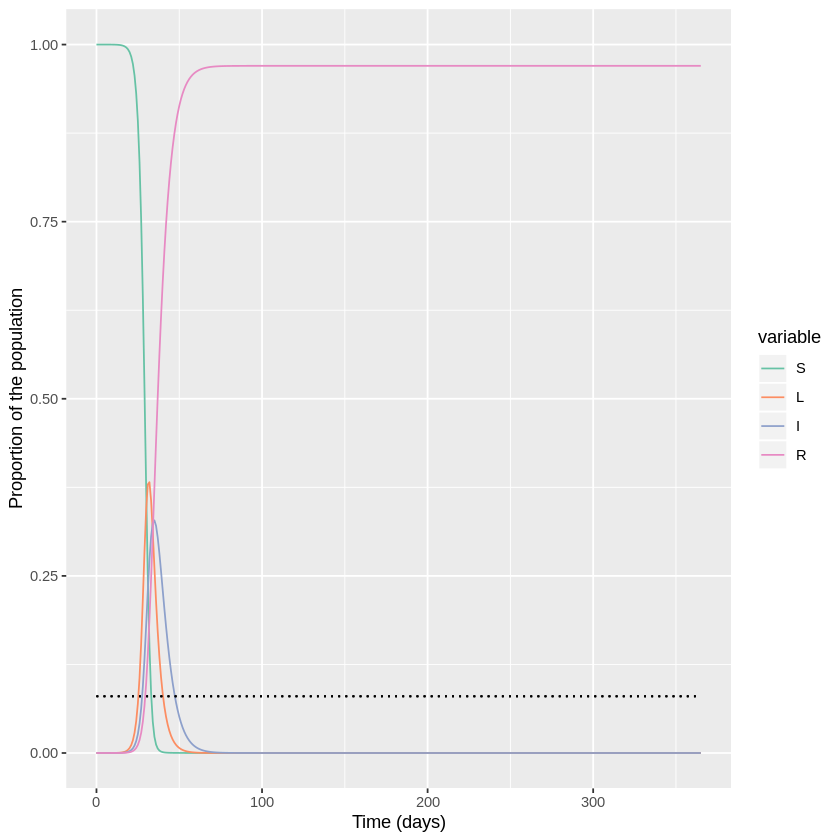

In [31]:
## and plot

require(reshape2)
require(ggplot2)

[SF # reshape our data for ggplot]
output_long <- melt(as.data.frame(output), id = "time")
# create a "proportion of population" variable
output_long$prop <- output_long$value / sum(initial_state_values)

 [SF why mod_plot? could maybe be a clearer variable name]
 [SF # pass our data to ggplot and configure display]
mod_plot <- ggplot(data = output_long)
mod_plot <- mod_plot +                                       
    aes(x = time, y = prop, colour = variable, group = variable) +  
    geom_line() +                                                          
    xlab("Time (days)")+                                                   
    ylab("Proportion of the population") +
    scale_colour_brewer(palette = "Set2")    # This colour palette is supposed to be 
                                             # colour-blind friendly. 
                                             # You can also try Set1, Set3
                                             # or you can set colours manually

# and add a horizontal line to indicate 8% prevalence
mod_plot <- mod_plot + geom_line(y = 0.08
                                 , linetype = "dotted"
                                 , colour = "black")

mod_plot

### 4.2 Manually calibrate to estimate $\beta$<a name='manual'></a> ([return to top](#top))

You can see that you don't need to plot all the compartments for this. You only need to see the prevalence of infected, **symptomatic** individuals - just the I compartment. So change the plot, and start changing beta.

[SF We don't need to plot all the compartments in order to calibrate $\beta$. We only need the prevalence of infected, **symptomatic** individuals - so just the **I** compartment. We can then adjust $\beta$ across a range of values.]

[1] "max. prev =  0.100856309287368"

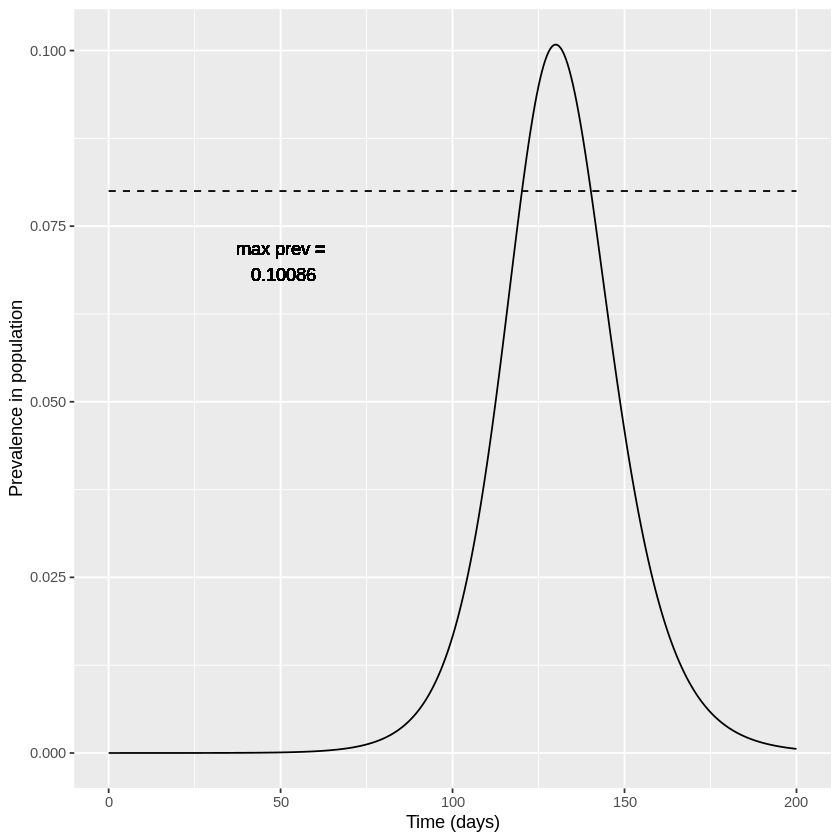

In [9]:
[SF move the respective comments to above the parameters and times definitions]

[SF # Manually adjust beta in steps from 0.21 to 0.45.
 # Observe that at beta=0.45, max prevalence rises above 0.08]
parameters <- c(mu = mu, r = r, gamma = gamma, beta = 0.45) 
# start beta from 0.21 and increase
# you can see if you try beta = 0.45, 
# you have max prevalence higher than 0.08 [ SF delete these three lines]

 [SF # You might notice from the model output above that you don't need to display the whole year.
 # Here we're plotting up to 200 days, with a 0.5 day timestep.]
times <- seq(from = 0, to = 200, by = 0.5) 
# you can see from the model output plot, 
# you might not need the whole year, 
# so change the "to" value if you like.
# Here we have used 200 days, with 0.5 day timestep. [SF delete these three lines]

[SF its good practice to put library definitions at the top]
require(deSolve) # just in case you skipped the first cell!
require(ggplot2)

[SF # Run our model with the current parameters]
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = SLIR_fn,
                            parms = parameters))

 [SF # create the prevalence variable, ie. proportion of Infected, and save in the output dataframe]
# create the prevalence, ie. proportion of Infected, variable 
# just in the output dataframe this time:
output$prev <- output$I / sum(initial_state_values)

  [SF # Get the maximum prevalence in this model run. This is all we really need...]
paste("max. prev = ", max(output$prev))
# this will show you the maximum prevalence
# you don't need to do the plot, you could just 
# have a look at the value - there's not a set of points 
# to fit to unlike previous examples. [SF delete these 4 lines]

   [SF # ... but if you do want to plot:]
# but if you do want to plot:
prev_plot <- ggplot(data = output)
prev_plot <- prev_plot +                                       
    aes(x = time, y = prev) +  
    geom_line() +                                                          
    xlab("Time (days)")+                                                   
    ylab("Prevalence in population") +
    scale_colour_brewer(palette = "Set2")

# you can add a horizontal line to indicate 8% prevalence
prev_plot <- prev_plot + geom_line(y = 0.08, linetype = "dashed")

# and/or you can add a label showing what the max prevalence is
prev_plot <- prev_plot + 
             geom_text(x=50, y=0.07, 
                       label=paste("max prev =\n", 
                                   signif(max(output$prev), 5)))
                                   # signif() rounds number to 
                                   # given number of sig. fig

prev_plot

So you could do this manually to find the estimate of beta, especially as it's only one parameter to change. See what value you get to get the maximum prevalence close to 0.08 (or visually, match the peak of the curve with the 0.08 prevalence line as closely as you can).

The estimate for beta we will use in the next section is 0.403.

## 5. Vaccine coverage<a name = 'coverage'></a> ([return to top](#top))


Now you have an estimate for beta, can you calculate an estimate for the vaccine coverage?

$$R_{eff} = (1-p) \times R_0 + p c_S \times R_0$$

$R_{eff}$ of course needs to be 1 or less, so to work out the critical vaccination coverage $p$:

$R_0 = \beta / (\gamma + \mu) $

In [10]:
R0 <- 0.403/(gamma+mu)
paste("R0 =", R0)

[1] "R0 = 1.95455"

Rearrange the equation for $R_{eff}$, substituting $R_{eff} = 1$ and $p = p_c$ to give:

\begin{align}
p_c & = \frac{1-\frac{1}{R_0}}{1-c_s} \\
\end{align}

$c_s$ is 1-0.8 = 0.2

In [11]:
c_s <- 0.2

p_c <- (1-(1/R0))/(1-c_s)

p_c

[1] 0.6104666

## 6. Extra: Towards automated calibration<a name = "auto"></a>

### 6.1 Distance measure function<a name = 'distfn'></a> ([return to top](#top))

Hopefully you could estimate beta manually. You might not need to automate the optimisation. But let's take the opportunity to write your own function to calculate a distance measurement. This is a simple, one-dimensional example, that you can easily generalise to two or more parameters.

What is the function to be minimised this time? 

You don't have timepoints and corresponding data, you just have one piece of information which is that maximum prevalence of symptomatics was 8%.

Here, we've written a function which calculates the squared distance between the peak of the curve and the maximum prevalence you choose.

In [12]:
[SF # Calculate the squared distance between maxprev and the maximum value of a provided function]
 [SF might want to rearrange the args to have maxprev last, since testparms and func are linked.
     I would give testparms a more descriptive name (what are you 'testing'?). Or... tbh I'd probably just call it parms!
     Then you're not changing variable names. cos it seems incongruous to have times=times and func=func but not parms=parms
     as we checked the other day, if you don't pass enough arguments R should throw an error when ode() is missing an arg.
     if you do that, you don't need the warning below]
SQ_maxprev <- function(testparms, maxprev, func) {
    # note the name of the argument in which you will give the parameters
    #...this will be fed into the ode() call here:

    result <- as.data.frame(ode(  y = initial_state_values  # named vector
                            , times = times                 # vector of times
                            ,  func = func                  # enter with arguments
                            , parms = testparms)) # this is going to take in the
                                                  # testparms arg from your 
                                                  # "outer" function. [SF not sure what's meant by outer function. probably can remove?]
     
    SQ <- ((max(result$I)/sum(initial_state_values)) - maxprev)^2
    
    return(SQ)
}

**Note:** it's really important to **check your argument names** here. You want the inner function - the `ode()` call which creates your model output - to take in the parameters which you give the outer function - your `SQ_maxprev()` function. So inside your `ode()` call it is important to state the parms argument as taking in the argument that you give the SQ_maxprev. This is why we've called this argument here testparms so it's easier to follow where each argument is going. 

Then when you finally run this new function (the cell below) you say that `testparms = parameters` as per the name of the vector you've assigned containing the parameters you are using for the model.

In [13]:
parameters <- c(mu = mu, r = r, gamma = gamma, beta = 0.4) 
                      
SQ_maxprev(testparms = parameters, maxprev = 0.08, func = SLIR_fn)                            

[1] 1.774991e-06

#### Visualising your distance measure against beta

You might want to try plotting different values of beta against your distance measure.  
If you've had a chance to investigate structures like loops, you might have constructed something like this:

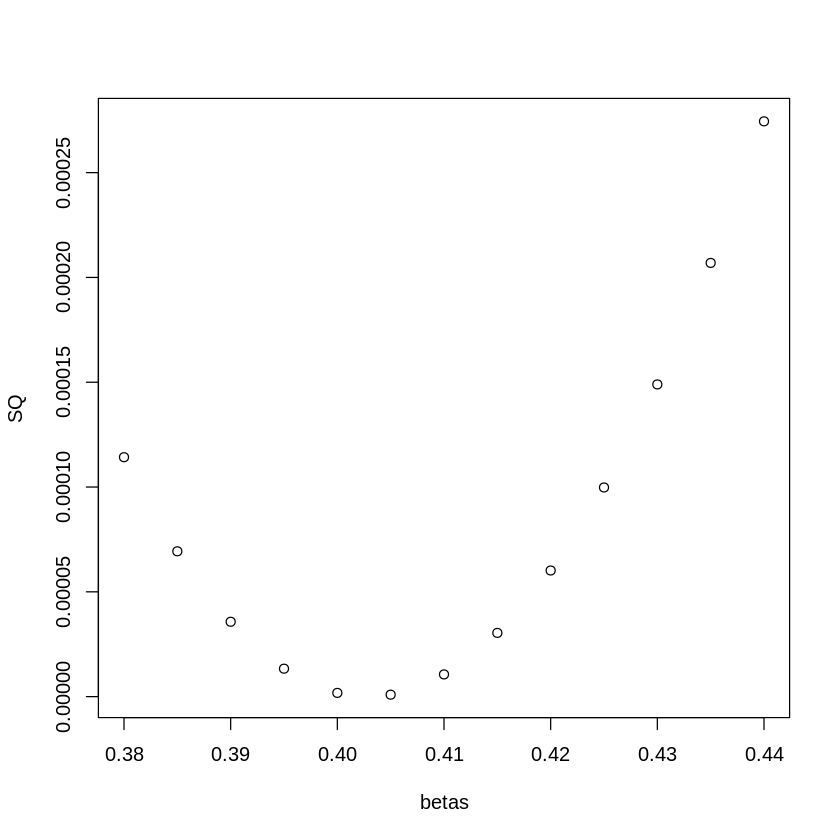

In [18]:
# create a vector of betas to test
betas <- seq(from = 0.38, to = 0.44, by = 0.005)

# create an empty numeric vector,
# same length as the betas vector
SQ <- numeric(length(betas)) 

for (i in 1:length(betas)) { 
## this loop runs along each value of beta in your vector, betas, in turn
    
    # create the parameters vector with the value of beta corresponding
    # to the current run of the loop
    parameters <- c(mu = mu, r = r, gamma = gamma, beta = betas[i]) 
    
    # then use your SQ_maxprev function and assign each output to the empty
    # SQ vector you created, element by element according to each run of the loop
    SQ[i]  <- SQ_maxprev(testparms = parameters, maxprev = 0.08, func = SLIR_fn)
    
} 

plot(betas, SQ)

###  6.2 Using `optim()` for this case of optimisation<a name = 'optim'></a> ([return to top](#top))

First, let's re-read the help file carefully. There is a potential problem!

In [ ]:
?optim 

# Will your function SQ_maxprev work?

Did you construct your `SQ_maxprev()` function the way it is done in this solutions file, or - did you think ahead and check how `optim()` needs the function constructed? Read the help file carefully.
How does the optim function want your function to be constructed?

If the function is not constructed in the way that `optim()` expects, you won't get the correct value for beta, which is supposed to correspond with the minimum distance from your max prevalence. The way we created the function above (in this solution file) will *not* work! There is a line in the help file which is relevant here: "A function to be minimized (or maximised), with first argument the vector of parameters over which minimization is to take place."   

The first argument tells `optim()` which parameters are to be changed. If your `SQ_maxprev()` function is structured the way it is in this solution so far, the first argument contains *all* the parameters, not just $\beta$. This is not what we need.

**If you don't create the function in the way `optim()` is expecting - you might not even get an error, because R will still run optim(), but you won't get the answer you are looking for!**

So, your function needs to be structured as follows:

In [16]:
[SF note if you make suggested changes to the function above, you'll want to do the same here.
  Btw I do find it's clearer to put the comments above the function definition.
  That said in some languages (Python) it's standard to put them below. So, dealer's choice.]
[SF # Update our function to correctly place beta as the first argument,
    # so that optim() recognises it as the parameter to change]
SQ_maxprev_beta <- function(testbeta, testparms, maxprev, func) {
# now, the first argument is beta. Then optim() will know that beta is the 
# parameter to change.
    
    testparms['beta'] <- testbeta # assign beta within the function
    result <- as.data.frame(ode(  y = initial_state_values  # named vector of
                            , times = times                 # vector of times
                            ,  func = func                  # enter with arguments
                            , parms = testparms))           # remember to use the correct
                                                            # argument name here
    
    SQ <- ((max(result$I)/sum(initial_state_values)) - maxprev)^2
    
    return(SQ)
}

Another issue will become apparent if you try running the function as you did in Week 7.  One-dimensional optimisation is a special case and requires you to use a particular method, i.e. you have to assign the method argument this time. This also means that you have to give `optim()` a lower and an upper value to search between.

In [21]:
beta_start <- 0.5

optim(par = c(beta = beta_start)
      , lower = 0.21, upper = 0.8
      , method = "Brent"
      , fn = SQ_maxprev_beta        ## the function to minimise the value from 
      , testparms = parameters
      , func = SLIR_fn         ## function to go into SQ_maxprev
      , maxprev = 0.08)        ## another argument for SQ_maxprev


$par
[1] 0.4028823

$value
[1] 5.609949e-18

$counts
function gradient 
      NA       NA 

$convergence
[1] 0

$message
NULL